# Tutorial 1: Basics of CrypTen Tensors

We now have a high-level understanding of how secure MPC works. Through these tutorials, we will explain how to use CrypTen to carry out secure operations on encrypted tensors. In this tutorial, we will introduce a fundamental building block in CrypTen, called a ```CrypTensor```.  ```CrypTensors``` are encrypted ```torch``` tensors that can be used for computing securely on data. 

CrypTen currently only supports secure MPC protocols (though we intend to add support for other advanced encryption protocols). Using the ```mpc``` backend, ```CrypTensors``` act as ```torch``` tensors whose values are encrypted using secure MPC protocols. Tensors created using the ```mpc``` backend are called ```MPCTensors```. We will go into greater detail about ```MPCTensors``` in Tutorial 2. 

Let's begin by importing ```crypten``` and ```torch``` libraries. (If the imports fail, please see the installation instructions in the README.)

In [1]:
import crypten
import torch
from crypten.config import cfg
import timeit
import crypten.communicator as comm
import logging
import matplotlib.pyplot as plt
import numpy as np

crypten.init()
# logging.getLogger().setLevel(logging.INFO)

# torch.set_num_threads(1)

# comm.get().set_verbosity(True)
# ... do stuff ..
# comm.get().print_communication_stats()

## Check truncation protocol

In [ ]:
l = 20
m = 2


import crypten.mpc as mpc

@mpc.run_multiprocess(world_size=2)
def test_trunc():
    for a in range(-2**2, 2**2):
        e = ((a * 2**16) // 2**m) % 2**64
        a_enc = crypten.cryptensor([a, a])
        a_raw = a_enc[0].reveal()
        y_enc = a_enc.egk_trunc_pr(l, m)
        y = y_enc.reveal()
        crypten.print("a=", a, "a_raw=", a_raw, "e=", e, "y=", y)
        crypten.print("\n")

test_trunc()

In [ ]:
import crypten.mpc as mpc

@mpc.run_multiprocess(world_size=2)
def test_sum():

    a_enc = crypten.cryptensor([2.1, 2.])
    b_enc = crypten.cryptensor(7.56)

    c_enc = a_enc * b_enc

    crypten.print(c_enc.get_plain_text())

test_sum()

In [44]:
import torch

import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)
def test_correctness_error():
    threshold_error = 2**20
    samples = 2**25
    tensor = torch.rand(samples) * 128
    result = tensor.clone()
    result = tensor * tensor
    a_enc = crypten.cryptensor(tensor)

    with cfg.temp_override({"encoder.trunc_method.prod": 'crypten'}):
        crypten.print("==== CrypTen ====")
        num_errors = 0
        a_sq_enc = a_enc * a_enc
        a_sq = a_sq_enc.get_plain_text()
        
        abs_diff = torch.abs(a_sq - result)
        # Check which elements are greater than or equal to threshold_error
        errors = abs_diff >= threshold_error
        # Count the number of such elements
        num_errors = torch.sum(errors).item()
        crypten.print("Total number of correctness errors:", num_errors)
        crypten.print("\n")
    
    with cfg.temp_override({"encoder.trunc_method.prod": 'egk'}):
        crypten.print("====   EGK   ====")
        num_errors = 0
        a_sq_enc = a_enc * a_enc
        a_sq = a_sq_enc.get_plain_text()
        
        abs_diff = torch.abs(a_sq - result)
        # Check which elements are greater than or equal to threshold_error
        errors = abs_diff >= threshold_error
        # Count the number of such elements
        num_errors = torch.sum(errors).item()
        crypten.print("Total number of correctness errors:", num_errors)
           

test_correctness_error()

==== CrypTen ====
Total number of correctness errors: 40


====   EGK   ====
Total number of correctness errors: 0


[None, None]

In [2]:
def print_diff(x, z_enc):
    diff = torch.abs(x - z_enc.get_plain_text()).numpy()
    relative = torch.abs((z_enc.get_plain_text()-x)/x)
    relative = relative[relative != float("inf")].numpy()
    relative = relative[~np.isnan(relative)]
    print(f"TAE: {diff.sum():e}, MAE: {diff.mean():e}, MRE: {relative.mean():e}, MAX: {diff.max():e}, ARGMAX: {diff.argmax()}")
    # print(diff[:print_terms])
    plt.plot(diff)
    
def print_diff_numb(x, z_enc):
    diff = torch.abs(x - z_enc.get_plain_text()).numpy()
    relative = torch.abs((z_enc.get_plain_text()-x)/x)
    relative = relative[relative != float("inf")].numpy()
    relative = relative[~np.isnan(relative)]
    print(f"TAE: {diff.sum():e}, MAE: {diff.mean():e}, MRE: {relative.mean():e}, MAX: {diff.max():e}, ARGMAX: {diff.argmax()}")
num_iters = 1
print_terms = 1

def print_app(name, end_time, start_time):
    print(f"  {name}: {num_iters} iterations in {end_time - start_time} sec.") # : {z_enc.get_plain_text()[:print_terms]}")


## Initial tests

In [6]:
x_enc = crypten.cryptensor(torch.arange(5, 15, 1))   
# m = torch.arange(3, 10, 1)   
crypten.print("\nx is:", x_enc.get_plain_text())
div_enc, mod_enc = x_enc.divmod(4)
crypten.print("\ndiv is:", div_enc.get_plain_text())
crypten.print("\nmod is:", mod_enc.get_plain_text())
div_enc, mod_enc = x_enc.egk_truncmod_pr(62, 2)
crypten.print("\ndiv is:", div_enc.get_plain_text())
crypten.print("\nmod is:", mod_enc.get_plain_text())


x is: tensor([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.])

div is: tensor([1.2500, 1.5000, 1.7500, 2.0000, 2.2500, 2.5000, 2.7500, 3.0000, 3.2500,
        3.5000])

mod is: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

div is: tensor([1.2500, 1.5000, 1.7500, 2.0000, 2.2500, 2.5000, 2.7500, 3.0000, 3.2500,
        3.5000])

mod is: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [17]:
import crypten.mpc as mpc

@mpc.run_multiprocess(world_size=1)
def test_sum():
    x_enc = crypten.cryptensor(torch.arange(5, 15, 1))   
    # m = torch.arange(3, 10, 1)   
    crypten.print("\nx is:", x_enc.get_plain_text())
    div_enc, mod_enc = x_enc.divmod(4)
    crypten.print("\ndiv is:", div_enc.get_plain_text())
    crypten.print("\nmod is:", mod_enc.get_plain_text())
    div_enc, mod_enc = x_enc.egk_truncmod_pr(62, 2)
    crypten.print("\ndiv is:", div_enc.get_plain_text())
    crypten.print("\nmod is:", mod_enc.get_plain_text())

test_sum()

KeyboardInterrupt: 

## Negative exp (Checked - Crypten)

Conclusion:
- If we do not consider the interval [-1, 0] the bior gets really close to exp (almost the same)
- CrypTen's approximation is always better.
- Split is better with one party (no error) but gets worse with two parties.

In [ ]:
#Construct example input CrypTensor
x = torch.arange(-64, 0, 0.001)
# x = x.reshape([1600, 10])
print(x.size())
# x = torch.tensor([0.01, 0.5])
x_enc = crypten.cryptensor(x)

print("Negative Exponential:")
# print("  Exact :", x.exp()[:print_terms])
with cfg.temp_override({"functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)
# with cfg.temp_override({"functions.exp_method": 'split', "functions.exp_all_neg": True}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.exp()  # Private
#     # print("  Nexp   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_app("Nexp", timeit.default_timer(), start1)
#     print_diff(x.exp(), z_enc)
# with cfg.temp_override({"functions.exp_method": 'haar', "functions.exp_all_neg": True}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.exp()  # Private
#     # print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_app("Haar", timeit.default_timer(), start1)
#     print_diff(x.exp(), z_enc)
with cfg.temp_override({"functions.exp_method": 'bior', "functions.exp_all_neg": True}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    # print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Bior", timeit.default_timer(), start1)
    print_diff(x.exp(), z_enc)

In [ ]:
plt.plot(z_enc.get_plain_text())

In [ ]:
#Construct example input CrypTensor
x = torch.arange(-8, 8, 0.3)
print(x.size())
# x = torch.tensor([0.01, 0.5])
x_enc = crypten.cryptensor(x)

print("Exponential:")
print("  Exact :", x.exp()[:print_terms])
with cfg.temp_override({"functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)
with cfg.temp_override({"functions.exp_method": 'haar', "functions.exp_all_neg": False}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)
with cfg.temp_override({"functions.exp_method": 'bior', "functions.exp_all_neg": False}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)

In [ ]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_exp():
    #Construct example input CrypTensor
    # x = torch.arange(start=0.001, end=10, step=0.001)
    x = torch.arange(-63, 0, 0.1)
    print(x.size())
    # x = torch.tensor([0.01, 0.5])
    x_enc = crypten.cryptensor(x)

    print("Exponential:")
    print("  Exact :", x.exp()[:print_terms])
    with cfg.temp_override({"functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.exp()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.exp(), z_enc)
    with cfg.temp_override({"functions.exp_method": 'split'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.exp()  # Private
        print("  Split:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.exp(), z_enc)
    with cfg.temp_override({"functions.exp_method": 'haar', "functions.exp_all_neg": True}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.exp()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.exp(), z_enc)
    with cfg.temp_override({"functions.exp_method": 'bior', "functions.exp_all_neg": True}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.exp()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.exp(), z_enc)

test_exp()

## Reciprocal (checked)

Conclusion:
- Sometimes the errors get completelly off (e.g. reciprocal, if I run it several times the bior case 1 in 5 times explodes. If I decrease the set from [0, 64] to [0, 63], there is no issue then.
- Note: Haar is more stable but the same happens. When we have a bad bior, then Haar is better.

In [ ]:
# x = torch.tensor([0.00005, 0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]) # , 5, 10, 50, 100 , 500, 1000, 5000, 10000, 50000])
x = torch.arange(start=1.1, end=64, step=0.1)
# x = torch.arange(start=1.01, end=10, step=0.01)
# x = x.reshape((63, 100))
x_enc = crypten.cryptensor(x)

print("\nReciprocal:")
# print("  Exact :", x.reciprocal()[:print_terms])
# with cfg.temp_override({"functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.reciprocal()  # Private
#     # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_app("Approx", timeit.default_timer(), start1)
#     print_diff(x.reciprocal(), z_enc)
# with cfg.temp_override({"functions.reciprocal_method": 'log', "functions.log_method": 'iter'}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.reciprocal()  # Private
#     # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_app("Log", timeit.default_timer(), start1)
#     print_diff(x.reciprocal(), z_enc)
with cfg.temp_override({"functions.reciprocal_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    # print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Haar", timeit.default_timer(), start1)
    print_diff(x.reciprocal(), z_enc)
# with cfg.temp_override({"functions.reciprocal_method": 'bior'}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.reciprocal()  # Private
#     # print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_app("Bior", timeit.default_timer(), start1)
#     print_diff(x.reciprocal(), z_enc)
with cfg.temp_override({"functions.reciprocal_method": 'bior1'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    # print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Bior 1", timeit.default_timer(), start1)
    print_diff(x.reciprocal(), z_enc)

In [ ]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_rec():
    #Construct example input CrypTensor
    # x = torch.arange(start=0.001, end=10, step=0.001)
    # x = torch.tensor([0.00005, 0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]) # , 5, 10, 50, 100 , 500, 1000, 5000, 10000, 50000])
    # x = torch.arange(1.0, 64, 0.001)
    # x = torch.arange(start=1.01, end=10, step=0.01)
    x = torch.arange(start=1.01, end=64, step=0.01)
    x = torch.arange(start=1, end=63.9, step=0.1)
    # x = x.reshape((63, 100))
    x_enc = crypten.cryptensor(x)

    print("\nReciprocal:")
    # print("  Exact :", x.reciprocal()[:print_terms])
    with cfg.temp_override({"functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Approx", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)
    with cfg.temp_override({"functions.reciprocal_method": 'log', "functions.log_method": 'iter'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Log", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)
    with cfg.temp_override({"functions.reciprocal_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Haar", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)
    with cfg.temp_override({"functions.reciprocal_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Bior", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)
    with cfg.temp_override({"functions.reciprocal_method": 'bior1'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Bior1", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)

test_rec()

## Logarithm (checked)

Conclusion:
- For torch.arange(0.1, 64, 0.1):
>- Bior has better accuracy
- For torch.arange(0.01, 64, 0.01):
>- Haar has better accuracy


Logarithm (LUT faster):
  Exact : tensor([-4.6052])
  Bior  : 1 iterations in 0.10819725300098071 sec.: tensor([-7.7378])
TAE: 6.053240e+01, MAE: 9.459666e-03, MRE: 5.024706e-03, MAX: 3.623935e+00, ARGMAX: 2


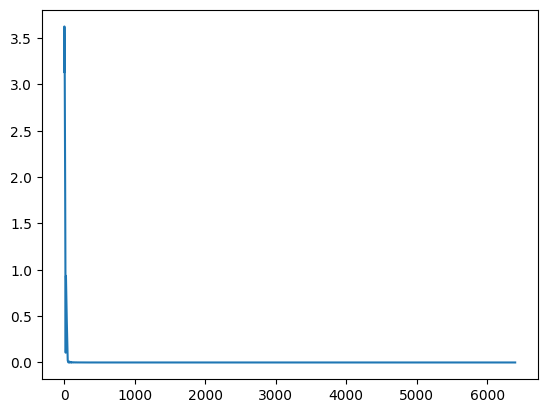

In [3]:
x = torch.arange(0.01, 64, 0.01)
x_enc = crypten.cryptensor(x)

print("\nLogarithm (LUT faster):")
print("  Exact :", x.log()[:print_terms])
# with cfg.temp_override({"functions.log_method": 'iter'}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.log()  # Private
#     print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_diff(x.log(), z_enc)
# with cfg.temp_override({"functions.log_method": 'haar'}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.log()  # Private
#     print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_diff(x.log(), z_enc)
with cfg.temp_override({"functions.log_method": 'bior', "encoder.trunc_method.lut": "crypten"}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.log()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.log(), z_enc)

In [3]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=1)
def test_log():
    rank = comm.get().get_rank()
    print("Rank is: ", rank)
    # x = torch.arange(5, 15, 1)
    x = torch.arange(0.01, 63.9, 0.01)
    x_enc = crypten.cryptensor(x)
    print("\nLogarithm (LUT faster):")
    print("  x :", x) if rank == 0 else None
    print("  Exact :", x.log()) if rank == 0 else None
    with cfg.temp_override({"functions.log_method": 'iter'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        # crypten.print("Out NR tensor: ", z_enc.get_plain_text()) 
        # if rank == 0:
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.log(), z_enc)
    with cfg.temp_override({"functions.log_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        # crypten.print("Out haar tensor: ", z_enc.get_plain_text())
        # if rank == 0:
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.log(), z_enc)
    with cfg.temp_override({"functions.log_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        # crypten.print("Out bior tensor: ", z_enc.get_plain_text())
        # if rank == 0:
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.log(), z_enc)

test_log()

Rank is:  0

Logarithm (LUT faster):
  x : tensor([1.0000e-02, 2.0000e-02, 3.0000e-02,  ..., 6.3870e+01, 6.3880e+01,
        6.3890e+01])
  Exact : tensor([-4.6052, -3.9120, -3.5066,  ...,  4.1568,  4.1570,  4.1572])
  Approx: 1 iterations in 0.20064145600190386 sec.: tensor([-12.1335])
TAE: 2.458238e+03, MAE: 3.847610e-01, MRE: 1.541322e-01, MAX: 8.458440e+00, ARGMAX: 5
  Haar  : 1 iterations in 0.07797189900156809 sec.: tensor([-2.3859])
TAE: 1.166436e+02, MAE: 1.825694e-02, MRE: 2.680442e-02, MAX: 6.542790e+00, ARGMAX: 6386
  Bior  : 1 iterations in 0.0802487580003799 sec.: tensor([-7.7378])
TAE: 1.967467e+02, MAE: 3.079461e-02, MRE: 1.104783e-02, MAX: 1.796522e+01, ARGMAX: 6380


[None]

## Sqrt (checked)

Conclusions:
- Sqrt does not perform well for numbers in [0,1] when compared to CrypTen's approximaton
- CrypTen has huge error for square root with world size > 2
__________________________________________________________________________________________
LUT 7

x = torch.arange(start=0.1, end=64, step=0.1)

- World size 1:
  Exact : 
TAE: 8.912110e-01, MAE: 1.394696e-03, MRE: 3.674109e-04, MAX: 8.734703e-03, ARGMAX: 86
  Bior  
TAE: 4.200375e-01, MAE: 6.573357e-04, MRE: 1.302702e-03, MAX: 1.001023e-01, ARGMAX: 0

- World size 2: Huge error for square root with more elements
  Exact : 
TAE: 1.183356e+10, MAE: 1.851887e+07, MRE: 3.312523e+06, MAX: 3.880408e+09, ARGMAX: 311 
  Bior  
TAE: 1.688408e+01, MAE: 2.642265e-02, MRE: 4.870367e-03, MAX: 8.172091e+00, ARGMAX: 637


x = torch.arange(start=0.01, end=64, step=0.01)

- World size 1:
  Exact : 
TAE: 9.005793e+00, MAE: 1.407375e-03, MRE: 5.083816e-04, MAX: 3.884277e-02, ARGMAX: 0
  Bior   : 
TAE: 4.248310e+00, MAE: 6.639021e-04, MRE: 1.442265e-03, MAX: 1.046040e-01, ARGMAX: 13

- World size 2:
 Exact : 
TAE: 8.076945e+10, MAE: 1.262220e+07, MRE: 2.258828e+06, MAX: 2.930533e+09, ARGMAX: 3151
  Bior   :  
TAE: 2.274174e+02, MAE: 3.553953e-02, MRE: 6.462289e-03, MAX: 8.490364e+00, ARGMAX: 6354

__________________________________________________________________________________________
LUT 6

x = torch.arange(start=0.1, end=64, step=0.1)

- World size 1
  Exact : 
TAE: 8.867714e+00, MAE: 1.387749e-03, MRE: 3.624862e-04, MAX: 8.783340e-03, ARGMAX: 852
  Bior  : 
TAE: 1.153096e+01, MAE: 1.804533e-03, MRE: 2.602629e-03, MAX: 1.489317e-01, ARGMAX: 18
- World size 2:

  Exact : 
TAE: 7.545336e+09, MAE: 1.180804e+07, MRE: 2.115324e+06, MAX: 3.516581e+09, ARGMAX: 308
   Bior   :  
TAE: 4.279654e+01, MAE: 6.697424e-02, MRE: 1.203176e-02, MAX: 8.326508e+00, ARGMAX: 634

In [ ]:
# x = torch.arange(1.0, 64, 0.01)
x = torch.arange(start=0.01, end=64, step=0.01)
x = torch.arange(start=0.1, end=64, step=0.1)
print(x.size())
x_enc = crypten.cryptensor(x)

print("\nSquare Root: (LUT faster)")
print("  Exact :", x.sqrt()[:print_terms])
# with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.sqrt()  # Private
#     print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_diff(x.sqrt(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sqrt()  # Private
    print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt(), z_enc)
# with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.sqrt()  # Private
#     print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
#     print_diff(x.sqrt(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'bior1', "functions.inv_sqrt_method": 'bior1'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sqrt()  # Private
    print("  Bior1  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt(), z_enc)

In [ ]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=1)
def test_sqrt():
    # x = torch.arange(1.0, 64, 0.01)
    x = torch.arange(start=0.1, end=64, step=0.1)
    # x = torch.arange(start=0.1, end=64, step=0.1)
    print(x.size())
    x_enc = crypten.cryptensor(x)

    print("\nSquare Root: (LUT faster)")
    print("  Exact :", x.sqrt()[:print_terms])
    with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sqrt()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sqrt(), z_enc)
    with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sqrt()  # Private
        print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
        print_diff_numb(x.sqrt(), z_enc)
    with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sqrt()  # Private
        print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
        print_diff_numb(x.sqrt(), z_enc)
    with cfg.temp_override({"functions.sqrt_method": 'bior1', "functions.inv_sqrt_method": 'bior1'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sqrt()  # Private
        print("  Bior1   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
        print_diff_numb(x.sqrt(), z_enc)

test_sqrt()

## Inv sqrt (checked - Haar)

Conclusion:
- Haar always performs better when the [0,1] is included.
- Sqrt does not perform well for numbers in [0,1] when compared to CrypTen's approximation
- CrypTen explodes for world size 2

  Exact :  
TAE: 3.567988e+09, MAE: 5.583706e+06, MRE: 3.113768e+07, MAX: 1.547179e+09, ARGMAX: 308
  
  Haar   :  
TAE: 3.635196e+00, MAE: 5.688883e-03, MRE: 6.517332e-03, MAX: 8.149562e-01, ARGMAX: 0
  
  Bior   : 
TAE: 1.249464e+02, MAE: 1.955343e-01, MRE: 7.823918e-02, MAX: 7.181410e+01, ARGMAX: 0

In [ ]:
x = torch.arange(0.1, 64, 0.1)
print(x.size())
x_enc = crypten.cryptensor(x)

print("\nInverse Square Root: (LUT faster)")
print("  Exact :", x.sqrt().reciprocal()[:print_terms])
with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sqrt().reciprocal(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt().reciprocal(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt().reciprocal(), z_enc)

In [ ]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)
def test_inv_sqrt():
    x = torch.arange(0.1, 64, 0.1)
    print(x.size())
    x_enc = crypten.cryptensor(x)

    print("\nInverse Square Root: (LUT faster)")
    print("  Exact :", x.sqrt().reciprocal()[:print_terms])
    with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.inv_sqrt()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sqrt().reciprocal(), z_enc)
    with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.inv_sqrt()  # Private
        print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
        print_diff_numb(x.sqrt().reciprocal(), z_enc)
    with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.inv_sqrt()  # Private
        print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
        print_diff_numb(x.sqrt().reciprocal(), z_enc)
    with cfg.temp_override({"functions.sqrt_method": 'bior1', "functions.inv_sqrt_method": 'bior1'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.inv_sqrt()  # Private
        print("  Bior1   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
        print_diff_numb(x.sqrt().reciprocal(), z_enc)

test_inv_sqrt()

## Sin (checked - Bior)

Conclusion:
- Bior is always supperior
- Interesting to comment: crypten's approximation gets worse for larger elements (with a max error for x=64 of ~5)

In [ ]:
x = torch.arange(0.1, 64, 0.1)
x_enc = crypten.cryptensor(x)
print("\nLogarithm (LUT faster):")
# print("  x :", x) if rank == 0 else None
# print("  Exact :", x.sin()) if rank == 0 else None
with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sin()  # Private
    # crypten.print("Out NR tensor: ", z_enc.get_plain_text())
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sin(), z_enc)
with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sin()  # Private
    # crypten.print("Out haar tensor: ", z_enc.get_plain_text())
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sin(), z_enc)
with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sin()  # Private
    # crypten.print("Out bior tensor: ", z_enc.get_plain_text())
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sin(), z_enc)

In [ ]:
import crypten.mpc as mpc
# x = torch.arange(0, 64, 0.001)
# x = torch.rand((2, 2))
# x = torch.arange(1, 10, 1)
# print(x.size())
# x_enc = crypten.cryptensor(x)
# print("Ref tensor: ", x.sin())

@mpc.run_multiprocess(world_size=2)
def test_sin():
    rank = 0
    x = torch.arange(0.1, 64, 0.1)
    x_enc = crypten.cryptensor(x)
    print("\nLogarithm (LUT faster):")
    # print("  x :", x) if rank == 0 else None
    # print("  Exact :", x.sin()) if rank == 0 else None
    with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        # crypten.print("Out NR tensor: ", z_enc.get_plain_text())
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sin(), z_enc)
    with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        # crypten.print("Out haar tensor: ", z_enc.get_plain_text())
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sin(), z_enc)
    with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        # crypten.print("Out bior tensor: ", z_enc.get_plain_text())
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sin(), z_enc)

test_sin()

## Cos (checked - Bior)

Conclusion:
- Same as Sin

In [ ]:
print("\nCos:")
print("  Exact :", x.cos()[:print_terms])
with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.cos(), z_enc)
with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.cos(), z_enc)
with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.cos(), z_enc)

In [ ]:
import crypten.mpc as mpc

@mpc.run_multiprocess(world_size=2)
def test_cos():
    rank = 0
    x = torch.arange(0.1, 64, 0.1)
    x_enc = crypten.cryptensor(x)
    print("\nLogarithm (LUT faster):")
    # print("  x :", x) if rank == 0 else None
    # print("  Exact :", x.cos()) if rank == 0 else None
    with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.cos()  # Private
        # crypten.print("Out NR tensor: ", z_enc.get_plain_text())
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.cos(), z_enc)
    with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.cos()  # Private
        # crypten.print("Out haar tensor: ", z_enc.get_plain_text())
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.cos(), z_enc)
    with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.cos()  # Private
        # crypten.print("Out bior tensor: ", z_enc.get_plain_text())
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.cos(), z_enc)

test_cos()

## Sigmoid (checked - Bior)

Conclusion:
- Bior is superior to Haar
- For 1 party it is superior to crypten
- For 2 parties wins against crypten only sometimes (the haar always loose)

In [ ]:
x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

print("\nSigmoid:")
print("  Exact :", x.sigmoid()[:print_terms])
with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sigmoid(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sigmoid(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sigmoid(), z_enc)

In [ ]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_sig():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    print("\nSigmoid:")
    print("  Exact :", x.sigmoid()[:print_terms])
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sigmoid(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sigmoid(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sigmoid(), z_enc) 

test_sig()

## Tanh (checked - Bior)

Conclusion:
- Bior is superior to Haar
- For 1 party it is superior to crypten
- For 2 parties, bior most of the times wins against crypten

In [ ]:
x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

print("Tanh:")
print("  Exact :", x.tanh()[:print_terms])
with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.tanh(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.tanh(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.tanh(), z_enc)

In [ ]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_tanh():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    print("Tanh:")
    print("  Exact :", x.tanh()[:print_terms])
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.tanh(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.tanh(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.tanh(), z_enc)

test_tanh()

## Erf (checked - Bior)

Checked

In [ ]:
x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

print("Erf:")
print("  Exact :", x.erf()[:print_terms])
with cfg.temp_override({"functions.erf_method": 'Taylor'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.erf(), z_enc)
with cfg.temp_override({"functions.erf_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.erf(), z_enc)
with cfg.temp_override({"functions.erf_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.erf(), z_enc)

In [ ]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=1)    
def test_erf():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    print("Erf:")
    print("  Exact :", x.erf()[:print_terms])
    with cfg.temp_override({"functions.erf_method": 'Taylor'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.erf(), z_enc)
    with cfg.temp_override({"functions.erf_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.erf(), z_enc)
    with cfg.temp_override({"functions.erf_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.erf(), z_enc)

test_erf()

## Gelu (checked - expression with Bior)

Conclusion:
- gelu with the erf expression gives better accuracy always

In [ ]:
# x = torch.arange(start=1.01, end=10, step=0.01)
# x_enc = crypten.cryptensor(x)

x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

gelu = x * (1 + (x / torch.sqrt(torch.tensor(2))).erf()) / 2
relu = x * (x > 0)

print("\nGelu:")
print("  Exact :", gelu)
with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'Taylor'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)
with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Erf", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)
with cfg.temp_override({"functions.gelu_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Haar", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)
with cfg.temp_override({"functions.gelu_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Bior", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)

In [ ]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_gelu():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    gelu = x * (1 + (x / torch.sqrt(torch.tensor(2))).erf()) / 2
    relu = x * (x > 0)

    print("\nGelu:")
    print("  Exact :", gelu)
    with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'Taylor'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.gelu()  # Private
        print_app("Approx", timeit.default_timer(), start1)
        print_diff_numb(gelu, z_enc)
    with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.gelu()  # Private
        print_app("Erf", timeit.default_timer(), start1)
        print_diff_numb(gelu, z_enc)
    with cfg.temp_override({"functions.gelu_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.gelu()  # Private
        print_app("Haar", timeit.default_timer(), start1)
        print_diff_numb(gelu, z_enc)
    with cfg.temp_override({"functions.gelu_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.gelu()  # Private
        print_app("Bior", timeit.default_timer(), start1)
        print_diff_numb(gelu, z_enc)

test_gelu()

## Silu (checked - expression with Bior)

Conclusion:
- silu with the sigmoid expression gives better accuracy always (by one order of magnitude)
- but the bior is also good.

In [ ]:
x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

silu = x * x.sigmoid()
relu = x * (x > 0)

print("\nSilu:")
# print("  Exact :", silu)
with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_tanh_method": 'reciprocal'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    print_diff(silu, z_enc)
with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Private
    print_app("Sigmoid", timeit.default_timer(), start1)
    print_diff(silu, z_enc)
with cfg.temp_override({"functions.silu_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Private
    print_app("Haar", timeit.default_timer(), start1)
    print_diff(silu, z_enc)
with cfg.temp_override({"functions.silu_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Privat6
    print_app("Bior", timeit.default_timer(), start1)
    print_diff(silu, z_enc)

In [ ]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=1)    
def test_silu():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    silu = x * x.sigmoid()
    relu = x * (x > 0)

    print("\nSilu:")
    # print("  Exact :", silu)
    with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_tanh_method": 'reciprocal'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.silu()  # Private
        print_app("Approx", timeit.default_timer(), start1)
        print_diff_numb(silu, z_enc)
    with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.silu()  # Private
        print_app("Sigmoid", timeit.default_timer(), start1)
        print_diff_numb(silu, z_enc)
    with cfg.temp_override({"functions.silu_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.silu()  # Private
        print_app("Haar", timeit.default_timer(), start1)
        print_diff_numb(silu, z_enc)
    with cfg.temp_override({"functions.silu_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.silu()  # Privat6
        print_app("Bior", timeit.default_timer(), start1)
        print_diff_numb(silu, z_enc)

test_silu()

#### Advanced mathematics
We are also able to compute more advanced mathematical functions on ```CrypTensors``` using iterative approximations. CrypTen provides MPC support for functions like reciprocal, exponential, logarithm, square root, tanh, etc. Notice that these are subject to numerical error due to the approximations used. 

Additionally, note that some of these functions will fail silently when input values are outside of the range of convergence for the approximations used. These do not produce errors because value are encrypted and cannot be checked without decryption. Exercise caution when using these functions. (It is good practice here to normalize input values for certain models.)